In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np

Normalizacion de los datos para el entrenamiento de la LSTM

- se eliminan valores atipicos
- se imputan esos valores
- se crea columna estacion que hace referencia a la estacion del año
- Se codifica la fecha y direccion del viento como variables ciclicas sen y cos


In [2]:
DataSet = pd.read_csv('../../../data/processed/Dataset_Particulas_contaminantes.csv',sep=';', decimal=',')
DataSet['fecha'] = pd.to_datetime(DataSet['fecha'])
# eliminamos la direccion del viento como variable, no aporta mayor informacion
# DataSet = DataSet.drop('dir_viento',axis=1)

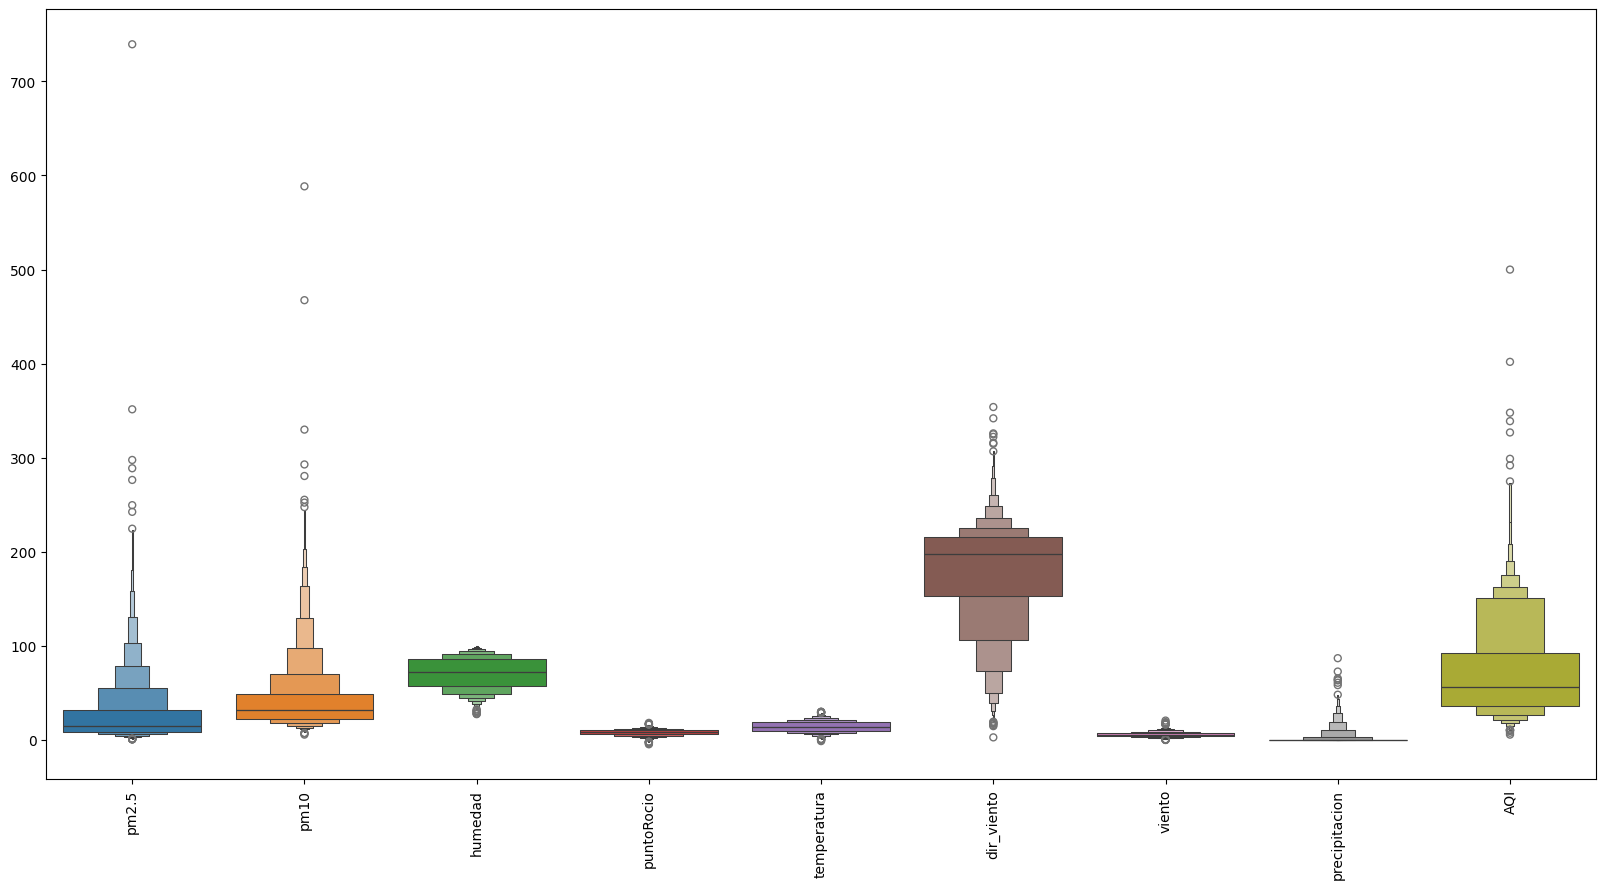

In [3]:
features = DataSet.drop(['fecha'], axis=1)
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
sns.color_palette("rocket", as_cmap=True)
plt.xticks(rotation=90)
plt.show()

ELIMINACION DE VALORES ATIPICOS

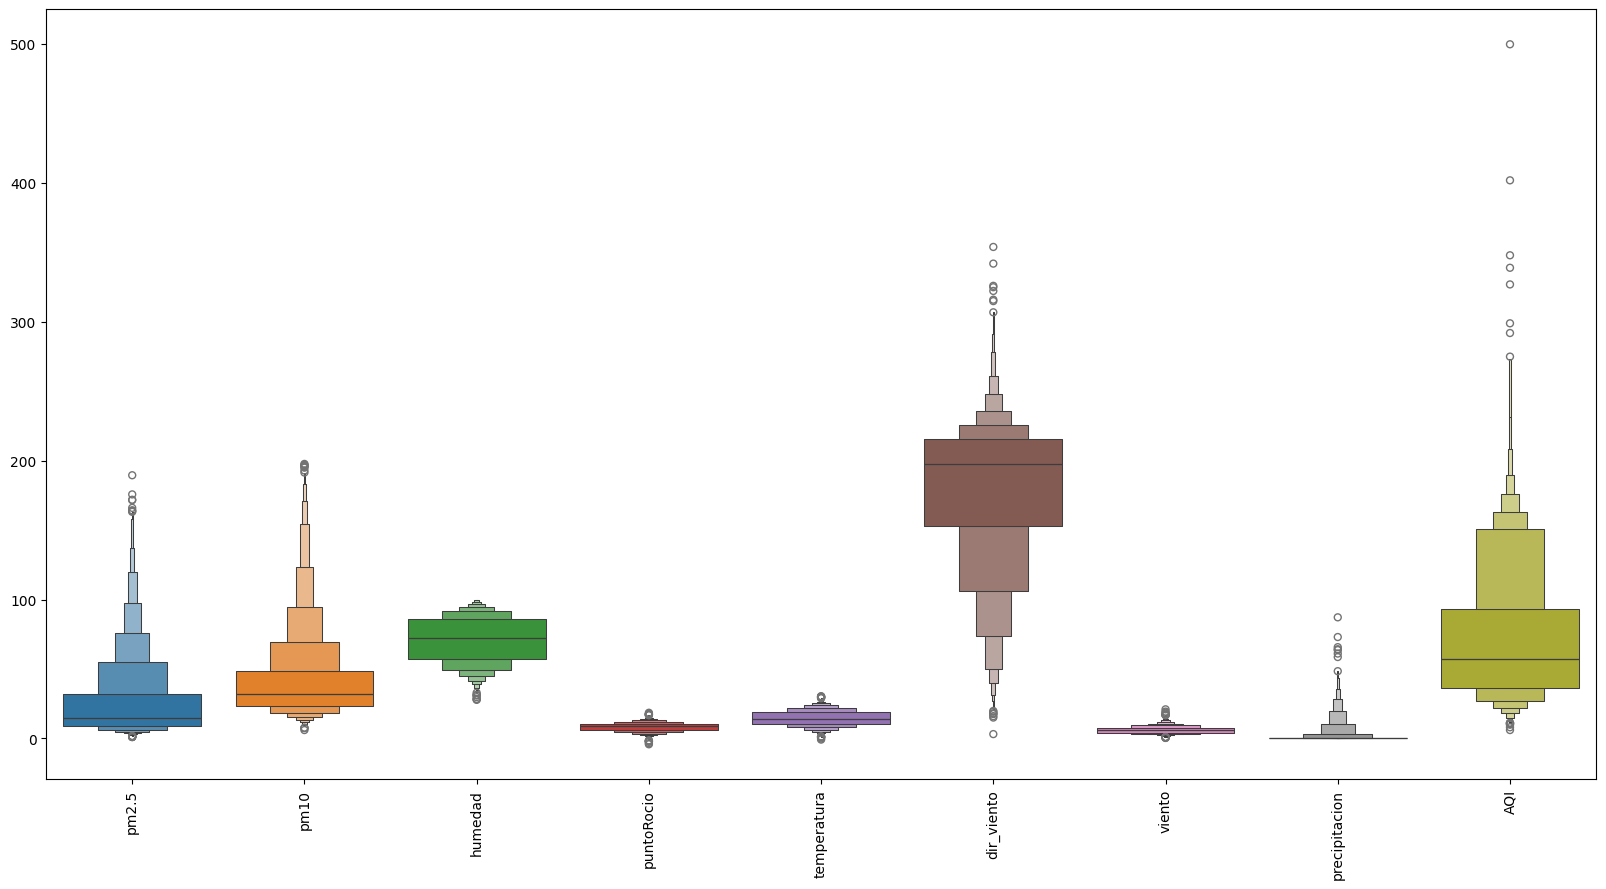

In [4]:
# Reemplazar valores atípicos con NaN
mask = (DataSet['pm2.5'] >= 200) | (DataSet['pm10'] >= 200)
DataSet.loc[mask, ['pm2.5', 'pm10']] = np.nan


# Creando una columna para el año para que se normalice 
DataSet['year'] = DataSet.fecha.dt.year
features = DataSet.drop(['fecha','year'], axis=1)
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
sns.color_palette("rocket", as_cmap=True)
plt.xticks(rotation=90)
plt.show()

In [5]:
rows_with_nan = DataSet[DataSet.isna().any(axis=1)]
print('missing data pm25 \n\n',rows_with_nan)

missing data pm25 

           fecha  pm2.5  pm10  humedad  puntoRocio  temperatura  dir_viento  \
136  2013-05-17    NaN   NaN  73.6667      3.4250       8.2667    184.0000   
141  2013-05-22    NaN   NaN  75.3333      6.0833      10.6917    146.0000   
533  2014-06-18    NaN   NaN  73.5833      6.0000      11.0000    190.0000   
842  2015-04-23    NaN   NaN  69.0000      7.5636      13.9364    150.9091   
847  2015-04-28    NaN   NaN  70.7273      9.5545      15.6364    140.9091   
1237 2016-05-22    NaN   NaN  91.6667      6.9120       8.2840    157.6400   
1256 2016-06-10    NaN   NaN  86.9565      3.6826       6.0609    197.1739   
1259 2016-06-13    NaN   NaN  96.9583      4.7333       5.1833    141.1250   
1272 2016-06-26    NaN   NaN  91.3750      2.1308       3.6692    170.3846   
1273 2016-06-27    NaN   NaN  90.3750      2.1375       3.8375    154.0417   
1487 2017-01-27    NaN   NaN  64.7500     15.6560      23.0120    189.3600   
1607 2017-05-27    NaN   NaN  87.5714      

imputacion KNNImputer para datos no existentes

In [6]:
from sklearn.impute import KNNImputer

# Asumiendo que 'DataSet' es tu DataFrame y tiene columnas 'fecha', 'pm2.5' y 'pm10'

# Convertir las fechas a formato numérico
DataSet['fecha_num'] = (pd.to_datetime(DataSet['fecha']) - pd.to_datetime(DataSet['fecha']).min()).dt.days

# Preparar los datos para la imputación
X = DataSet[['fecha_num', 'pm2.5', 'pm10','AQI']].values

# Realizar la imputación usando k-NN
knn_imputer = KNNImputer(n_neighbors=2)
X_imputed = knn_imputer.fit_transform(X)

# Crear un nuevo DataFrame con los valores imputados
df_imputed = pd.DataFrame(X_imputed, columns=['fecha_num', 'pm2.5_imputed', 'pm10_imputed','AQI_imputed'])

# Reemplazar las columnas antiguas por las imputadas
DataSet['pm2.5'] = df_imputed['pm2.5_imputed']
DataSet['pm10'] = df_imputed['pm10_imputed']
DataSet['AQI'] = df_imputed['AQI_imputed']

# Eliminar la columna 'fecha_num'
DataSet = DataSet.drop('fecha_num', axis=1)
df_imputed.head()

,fecha_num,pm2.5_imputed,pm10_imputed,AQI_imputed
0,0.0,9.3612,25.2396,39.0
1,1.0,13.7865,36.1072,54.0
2,2.0,12.2568,29.2324,51.0
3,3.0,12.6945,33.1919,52.0
4,4.0,8.6662,26.3441,36.0


calculamos nuevamente las etiquetas de calidad del aire

In [7]:
# Definir los bordes de los bins (contenedores) para los niveles de calidad del aire
bins = [0, 50, 100, 150, 200, 300, float('inf')]

# Definir las etiquetas para los niveles de calidad del aire
labels = ['Bueno', 'Moderado', 'Insalubre para grupos sensibles', 'Insalubre', 'Muy insalubre', 'Peligroso']

# Crear la nueva columna 'calidad_aire' usando pd.cut
DataSet['calidad_aire'] = pd.cut(DataSet['AQI'], bins=bins, labels=labels, right=False)  # right=False para que los intervalos sean semi-abiertos a la izquierda

# Verificar el conteo de valores en la nueva columna
conteo_calidad_aire = DataSet['calidad_aire'].value_counts()

CODIFICACION DE FECHA

BUSCAMOS DAR REPRESENTATIVIDAD DE LA FECHA 

-PUEDE DESCOMPONER DE FORMA CICLICA CON FUNCIONES SENO Y COSENO
-DESCOMPONER FECHA SEGUN ESTACIONES , DEL 4 AL 1 , INVIERNO-OTOÑO-PRIMAVERA-VERANO



In [8]:
# Definir la función para determinar la estación del año en el hemisferio sur
def get_season_southern_hemisphere(date):
    year = date.year if date.month > 2 else date.year-1
    seasons = {
        1: (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year+1, month=3, day=20)),  # Verano
        3: (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),    # Otoño
        4: (pd.Timestamp(year=year, month=6, day=21), pd.Timestamp(year=year, month=9, day=22)),    # Invierno
        2: (pd.Timestamp(year=year, month=9, day=23), pd.Timestamp(year=year, month=12, day=20)),   # Primavera
    }



    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return season
    return 1  # Si ninguna condición se cumple, es Verano por defecto



# Aplicar la función para obtener la estación
DataSet['estacion'] = DataSet['fecha'].apply(get_season_southern_hemisphere)

DataSet.head()

,fecha,pm2.5,pm10,humedad,puntoRocio,temperatura,dir_viento,viento,precipitacion,AQI,calidad_aire,year,estacion
0,2013-01-01,9.3612,25.2396,44.8462,10.0615,25.0308,174.6154,3.7692,0.0,39.0,Bueno,2013,1
1,2013-01-02,13.7865,36.1072,43.3077,12.1000,25.8000,256.1538,3.7692,0.0,54.0,Moderado,2013,1
2,2013-01-03,12.2568,29.2324,62.8462,13.4000,21.2462,213.0769,2.7692,0.0,51.0,Moderado,2013,1
3,2013-01-04,12.6945,33.1919,68.6923,13.5385,19.6000,154.6154,2.7692,0.0,52.0,Moderado,2013,1
4,2013-01-05,8.6662,26.3441,53.5385,12.3231,23.3231,235.3846,3.9231,0.0,36.0,Bueno,2013,1


codificacion ciclica de la fecha y la direccion del viento


In [9]:
# Asegurándonos de que los datos en la columna 'fecha' están en formato datetime
DataSet['fecha'] = pd.to_datetime(DataSet["fecha"])

# Función para codificar datetime en parámetros cíclicos
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# Creando una columna para el mes y codificándola
DataSet ['mes'] = DataSet.fecha.dt.month
DataSet = encode(DataSet, 'mes', 12)

# Creando una columna para el día y codificándola
DataSet['dia'] = DataSet.fecha.dt.day
DataSet = encode(DataSet, 'dia', 31)


# Función para codificar la dirección del viento
def encode_wind_direction(data, col):
    max_val = 360
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# Aplicando la función a la columna de dirección del viento
DataSet = encode_wind_direction(DataSet, 'dir_viento')

# Mostrando las primeras filas del dataframe
DataSet.head()

,fecha,pm2.5,pm10,humedad,puntoRocio,temperatura,dir_viento,viento,precipitacion,AQI,...,year,estacion,mes,mes_sin,mes_cos,dia,dia_sin,dia_cos,dir_viento_sin,dir_viento_cos
0,2013-01-01,9.3612,25.2396,44.8462,10.0615,25.0308,174.6154,3.7692,0.0,39.0,...,2013,1,1,0.5,0.866025,1,0.201299,0.979530,0.093841,-0.995587
1,2013-01-02,13.7865,36.1072,43.3077,12.1000,25.8000,256.1538,3.7692,0.0,54.0,...,2013,1,1,0.5,0.866025,2,0.394356,0.918958,-0.970942,-0.239316
2,2013-01-03,12.2568,29.2324,62.8462,13.4000,21.2462,213.0769,2.7692,0.0,51.0,...,2013,1,1,0.5,0.866025,3,0.571268,0.820763,-0.545764,-0.837939
3,2013-01-04,12.6945,33.1919,68.6923,13.5385,19.6000,154.6154,2.7692,0.0,52.0,...,2013,1,1,0.5,0.866025,4,0.724793,0.688967,0.428692,-0.903451
4,2013-01-05,8.6662,26.3441,53.5385,12.3231,23.3231,235.3846,3.9231,0.0,36.0,...,2013,1,1,0.5,0.866025,5,0.848644,0.528964,-0.822984,-0.568065


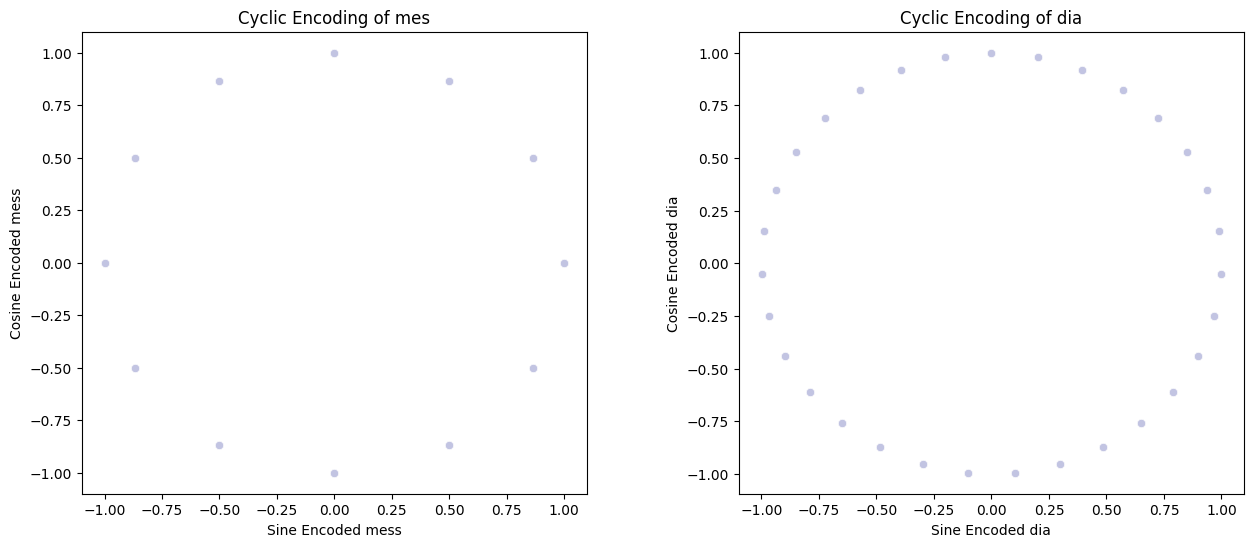

In [10]:
# Crear una figura y un conjunto de subtramas
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 fila, 2 columnas de subtramas

# Gráfico 1: Meses

sns.scatterplot(x="mes_sin", y="mes_cos", data=DataSet, color="#C2C4E2", ax=axes[0])
axes[0].set_title("Cyclic Encoding of mes")
axes[0].set_ylabel("Cosine Encoded mess")
axes[0].set_xlabel("Sine Encoded mess")

# Gráfico 2: Días
sns.scatterplot(x='dia_sin', y='dia_cos', data=DataSet, color="#C2C4E2", ax=axes[1])
axes[1].set_title("Cyclic Encoding of dia")
axes[1].set_ylabel("Cosine Encoded dia")
axes[1].set_xlabel("Sine Encoded dia")

# Ajustar el espacio entre los dos subgráficos
plt.subplots_adjust(wspace=0.3)

plt.show()

In [11]:
data_MinMaxScaler = DataSet.copy()
# columnas numericas
cols = data_MinMaxScaler.select_dtypes(include=[float, int]).columns.tolist()

# Crea el escalador
scaler_minmax = MinMaxScaler()

# Ajusta el escalador solo en las columnas numéricas y transforma
data_MinMaxScaler[cols] = scaler_minmax.fit_transform(data_MinMaxScaler[cols])

In [12]:
import pickle

# Asumiendo que 'scaler_minmax' es tu objeto MinMaxScaler ya entrenado
with open('../scaler_minmax.pkl', 'wb') as file:
    pickle.dump(scaler_minmax, file)

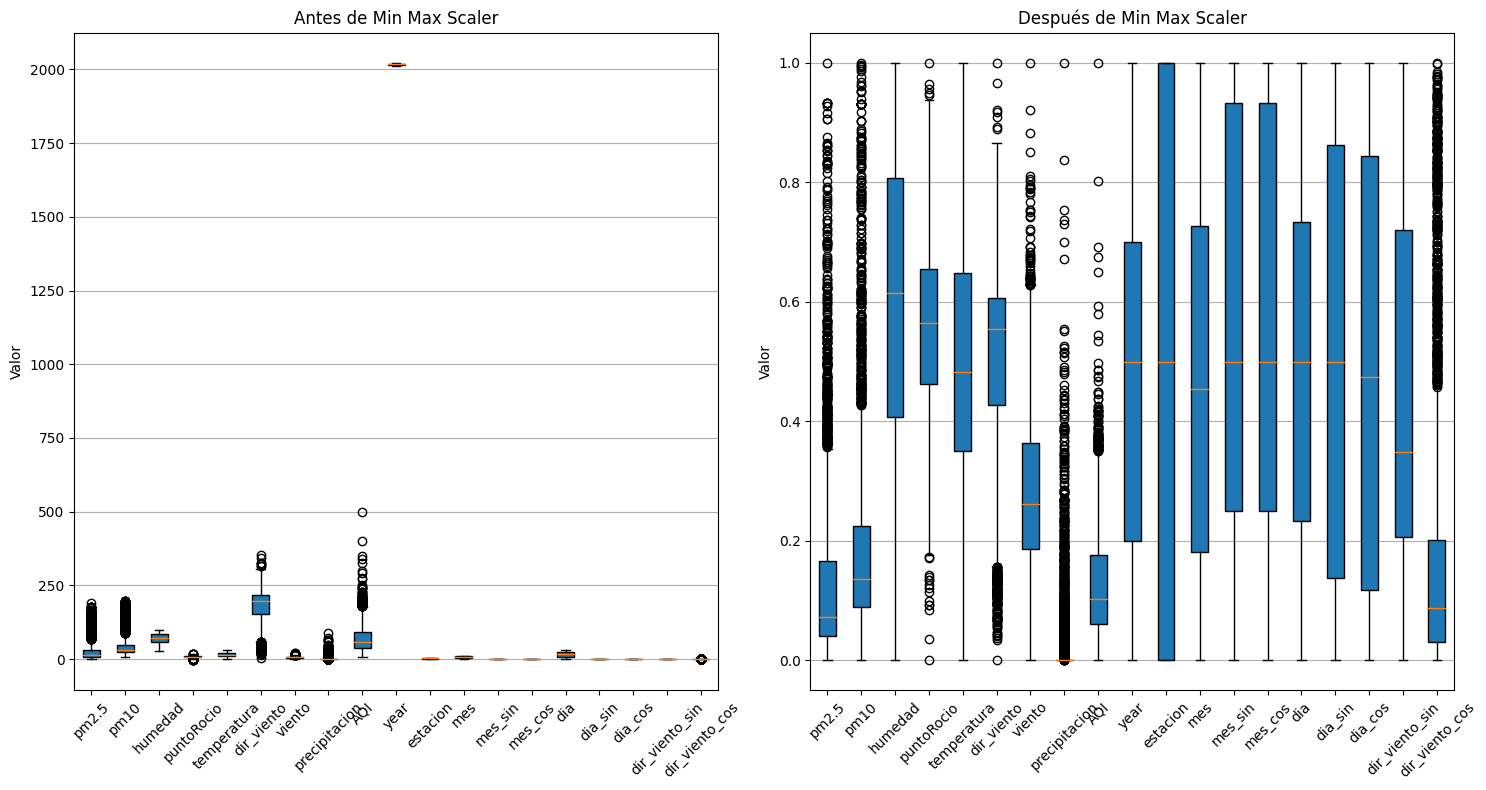

In [13]:
cols_numericas = data_MinMaxScaler.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(15, 8))

# Subplot 1: Antes de Min Max Scaler
plt.subplot(1, 2, 1)
plt.boxplot([DataSet[col] for col in cols_numericas], vert=True, patch_artist=True) # añade vert=True para gráficos verticales, patch_artist=True para relleno
plt.title('Antes de Min Max Scaler')
plt.xticks(range(1, len(cols_numericas) + 1), cols_numericas, rotation=45) # Para rotar los nombres para mejor lectura
plt.ylabel('Valor')  # Etiqueta para el eje y
plt.grid(axis='y')

# Subplot 2: Después de Min Max Scaler
plt.subplot(1, 2, 2)
plt.boxplot([data_MinMaxScaler[col] for col in cols_numericas], vert=True, patch_artist=True)
plt.title('Después de Min Max Scaler')
plt.xticks(range(1, len(cols_numericas) + 1), cols_numericas, rotation=45) 
plt.ylabel('Valor')
plt.grid(axis='y')

plt.tight_layout()

# Guardar la imagen
ruta_guardado = '../../explore/imagenes/normalizacion_MinMax_all_rnn.png'  # Reemplaza con tu ruta
plt.savefig(ruta_guardado, format='png', dpi=300)

plt.show()

In [14]:
path = './Dataset_MinMax.csv'
data_MinMaxScaler.to_csv(path, sep=';',index=False, float_format='%.4f', decimal=',')